In [1]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.numpy as jnp
import equinox as eqx
import sys
from scipy.stats import mode
from scipy.optimize import curve_fit
from scipy.integrate import trapz
import json
from scipy.stats import lognorm
from numpy.random import Generator, PCG64
import pytensor
import pymc as pm
import lineax as lxi
import xarray as xr

sys.path.append("./models/")
from orton_2009_copy import *



jax.config.update("jax_enable_x64", True)
rng = Generator(PCG64())

%matplotlib inline
# plt.style.use('/home/nlinden/.matplotlib/custom.mplstyle')
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *
from utils import *

%env CUDA_VISIBLE_DEVICES=1


env: CUDA_VISIBLE_DEVICES=1


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
################ LOAD in DATA ################
savedir = '../../results/MAPK/param_est/Keyes_2020_data/'


# load in the model info 
model_info = json.load(open('./param_est/model_info.json', 'r'))
model_names = ['orton_2009']
display_names = [model_info[model]['display_name'] for model in model_names]

idata = {'CYTO':{},'PM':{}}
posterior_samples = {'CYTO':{},'PM':{}}
sample_times = {'CYTO':{},'PM':{}}

for model in model_names:
    for compartment in ['CYTO','PM']:
        idata[compartment][model], _, sample_times[compartment][model] = load_smc_samples_to_idata(savedir+compartment+'/' + model + '/' + model +'_smc_samples.json', sample_time=True)
        posterior_samples[compartment][model] = np.load(savedir+compartment+'/' + model + '/' + model +'_posterior_predictive_samples.npy')

# # shin has 4000 samples so downsample to 2000
# idxs = rng.choice(np.arange(4000), size=2000, replace=False)
# posterior_samples['shin_2014'] = posterior_samples['shin_2014'][idxs,:,:]

# load in the training data
dat = {'CYTO':{'inputs':None, 'data':None,'data_std':None, 'times':None},
       'PM':{'inputs':None, 'data':None,'data_std':None, 'times':None}}
dat['CYTO']['inputs'], dat['CYTO']['data'], dat['CYTO']['data_std'], \
    dat['CYTO']['times'] = load_data_json('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO.json', data_std=True, time=True)
dat['PM']['inputs'], dat['PM']['data'], dat['PM']['data_std'], \
    dat['PM']['times'] = load_data_json('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM.json', data_std=True, time=True)
data_time_to_mins = 60

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest green
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

colors = ['#762a83','#9970ab','#c2a5cf','#e7d4e8','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']

In [3]:
data_file = '../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-'
EGF_conversion_factor = 602214
free_params = 'km_Erk_Activation,k1_C3G_Deactivation,km_Erk_Deactivation,k1_P90Rsk_Deactivation,k1_Sos_Deactivation'
input_state = 'EGF'
ERK_states = 'ErkActive'
prior_family = "[['LogNormal(mu=13.822823751258499)',['sigma']],['LogNormal(mu=0.9162907318741551)',['sigma']],['LogNormal(mu=15.067270166119108)',['sigma']],['LogNormal(mu=-5.298317366548036)',['sigma']],['LogNormal(mu=0.9162907318741551)',['sigma']]]"
rtol = 1e-6
atol = 1e-6
time_conversion_factor = 60

print('Processing model {}.'.format(model_names[0]))
model = orton_2009_mod(transient=False)

# get parameter names and initial conditions
p_dict, plist = model.get_nominal_params()
y0_dict, y0 = model.get_initial_conditions()
# load the data
# HF96 model is in seconds, so times is in seconds, so we set the data_time_to_mins to 60
inputs_CYTO, data_CYTO, data_std_CYTO, times_CYTO = load_data_json(data_file+'CYTO.json', data_std=True, time=True)
inputs_PM, data_PM, data_std_PM, times_PM = load_data_json(data_file+'PM.json', data_std=True, time=True)
data_time_to_mins = 60

# convert EGF to required units
inputs_native_units_CYTO = inputs_CYTO * EGF_conversion_factor
inputs_native_units_PM = inputs_PM * EGF_conversion_factor

# get the params to sample
analyze_params = free_params.split(',')
free_param_idxs = [list(p_dict.keys()).index(p) for p in analyze_params]

# get the EGF index and ERK indices
state_names = list(y0_dict.keys())
EGF_idx = state_names.index(input_state)
ERK_indices = [state_names.index(s) for s in ERK_states.split(',')]

# construct the strings to make priors and constants
prior_param_dict = set_prior_params(model_names[0], list(p_dict.keys()), plist, free_param_idxs, prior_family=prior_family, savedir=savedir, saveplot=False)

plt.close('all')

def ERK_stim_traj_CYTO(p, model, max_time, y0, output_states):
    traj = solve_traj(model, y0, p, max_time, output_states, times_CYTO/time_conversion_factor, rtol, atol)
    # return normalized trajectory
    return [(traj - np.min(traj)) / (np.max(traj) - np.min(traj))], traj

def ERK_stim_traj_PM(p, model, max_time, y0, output_states):
    traj = solve_traj(model, y0, p, max_time, output_states, times_PM/time_conversion_factor, rtol, atol)
    # return normalized trajectory
    return [(traj - np.min(traj)) / (np.max(traj) - np.min(traj))], traj

times = np.linspace(0, 42, 85)*60
def ERK_stim_traj(p, model, max_time, y0, output_states):
    traj = solve_traj(model, y0, p, max_time, output_states, times/time_conversion_factor, rtol, atol)
    # return normalized trajectory
    return [(traj - np.min(traj)) / (np.max(traj) - np.min(traj))], traj


y0_dict_rap_knockdown = y0_dict.copy()
y0_dict_rap_knockdown['Rap1Inactive'] = 0.0
y0_rap_knockdown = tuple(y0_dict_rap_knockdown.values())

# make initial conditions that reflect the inputs
y0_EGF_ins_CYTO = construct_y0_EGF_inputs(inputs_native_units_CYTO, np.array([y0]), EGF_idx)
y0_EGF_ins_PM = construct_y0_EGF_inputs(inputs_native_units_PM, np.array([y0]), EGF_idx)

y0_EGF_ins_CYTO_rap1_KD = construct_y0_EGF_inputs(inputs_native_units_CYTO, np.array([y0_rap_knockdown]), EGF_idx)
y0_EGF_ins_PM_rap1_KD = construct_y0_EGF_inputs(inputs_native_units_PM, np.array([y0_rap_knockdown]), EGF_idx)
max_input_idx = np.argmax(inputs_native_units_CYTO) # get index of max input

# construct the pymc model
# Note: We do not use the build_pymc_model function, because we need to 
#   build a model that runs the simulator three times for each input level
pymc_model_CYTO = build_pymc_model(prior_param_dict, [data_CYTO], y0_EGF_ins_CYTO[0], 
        ERK_indices, np.max(times_CYTO/time_conversion_factor), diffrax.ODETerm(model), simulator=ERK_stim_traj_CYTO, data_sigma=[data_std_CYTO])

pymc_model_CYTO_rap1_KD = build_pymc_model(prior_param_dict, [data_CYTO], y0_EGF_ins_CYTO_rap1_KD[0], 
        ERK_indices, np.max(times_CYTO/time_conversion_factor), diffrax.ODETerm(model), simulator=ERK_stim_traj_CYTO, data_sigma=[data_std_CYTO])

pymc_model_PM = build_pymc_model(prior_param_dict, [data_PM], y0_EGF_ins_PM[0],
        ERK_indices, np.max(times_PM/time_conversion_factor), diffrax.ODETerm(model), simulator=ERK_stim_traj_PM, data_sigma=[data_std_PM])

pymc_model_PM_rap1_KD = build_pymc_model(prior_param_dict, [data_PM], y0_EGF_ins_PM_rap1_KD[0],
        ERK_indices, np.max(times_PM/time_conversion_factor), diffrax.ODETerm(model), simulator=ERK_stim_traj_PM, data_sigma=[data_std_PM])

Processing model orton_2009.
k1_Sos_Deactivation 4.75 0.25
pm.LogNormal("k1_Sos_Deactivation",sigma=0.3902194510262181, mu=0.9162907318741551, )
k1_P90Rsk_Deactivation 0.0095 0.0005
pm.LogNormal("k1_P90Rsk_Deactivation",sigma=0.3902194510262179, mu=-5.298317366548036, )
km_Erk_Deactivation 6643331.0 349649.0
pm.LogNormal("km_Erk_Deactivation",sigma=0.39021945102621847, mu=15.067270166119108, )
km_Erk_Activation 1913946.0 100734.0
pm.LogNormal("km_Erk_Activation",sigma=0.3902194510262182, mu=13.822823751258499, )
k1_C3G_Deactivation 4.75 0.25
pm.LogNormal("k1_C3G_Deactivation",sigma=0.3902194510262181, mu=0.9162907318741551, )


In [45]:
def plot_trajectory_responses_oneAxis(fig, ax, samples, data, inputs, times, legend_filename, input_name='EGF', 
    output_name='% maximal ERK activity', data_std=0.1, data_downsample=3, colors=['c'], width=3.0, height=3.0):

    # fig, ax = get_sized_fig_ax(width, height)

    if len(samples.shape) > 2:
        nsamples, ninputs,_ = samples.shape
    else:
        nsamples, _ = samples.shape
        ninputs = 1

    for idx in range(ninputs):
        if ninputs > 1:
            sample = samples[:,idx,:]
        else:
            sample = samples

        tr_dict =  {'run':{}, 'timepoint':{}, 'ERK_act':{}}
        names = ['run'+str(i) for i in range(nsamples)]
        idxs = np.linspace(0, (nsamples*times.shape[0]-1), nsamples*times.shape[0])
        cnt = 0
        for i in range(nsamples):
            for j in range(times.shape[0]):
                    tr_dict['run'][int(idxs[cnt])] = names[i]
                    tr_dict['timepoint'][int(idxs[cnt])] = times[j]
                    tr_dict['ERK_act'][int(idxs[cnt])] = sample[i,j]
                    cnt += 1
        tr_df = pd.DataFrame.from_dict(tr_dict)

        sns.lineplot(data=tr_df,
                    x='timepoint',
                    y='ERK_act',
                    color=colors[idx],
                    legend=True,
                    label='[' + input_name + '] = {:.3f} (nM)'.format(inputs[idx]),
                    errorbar=('pi', 95), # percentile interval form 2.5th to 97.5th
                    ax=ax)

    # ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0.0, max(times)])

    # plot data
    if ninputs > 1:
        for idx,dat in enumerate(data):
            ax.errorbar(times[::data_downsample], np.squeeze(dat)[::data_downsample], yerr=data_std[idx][::data_downsample], fmt='o', linewidth=1.0, markersize=0.1, color='k')
    else:
        ax.errorbar(times[::data_downsample], np.squeeze(data)[::data_downsample], yerr=data_std[::data_downsample], fmt='o', linewidth=1.0, markersize=0.1, color='k')

    ax.set_xlabel('time (min)')
    ax.set_ylabel(output_name)

    leg = ax.legend(loc='right', bbox_to_anchor=(2.5,0.5))
    export_legend(leg, filename=legend_filename)
    leg.remove()

    return fig, ax

def create_posterior_predictive(model, posterior_idata, mapk_model_name, data, inputs, savedir, 
            seed=np.random.default_rng(seed=123), trajectory=False, times=None, data_std=None, fig_ax=(None,None)):
    """ Creates prior predictive samples plot of the stimulus response curve.
    """

    # sample from the posterior predictive
    with model:
        posterior_predictive = pm.sample_posterior_predictive(posterior_idata, model=model, 
                                                              random_seed=seed)

    # extract llike values
    posterior_llike = np.squeeze(posterior_predictive.posterior_predictive['llike'].values)

    # generate the plot
    if not trajectory:
        # reshape accordingly
        nchains,nsamples,ninputs=posterior_llike.shape
        posterior_llike = np.reshape(posterior_llike, (nchains*nsamples, ninputs))

        fig, ax = plot_stimulus_response_curve(posterior_llike, data, inputs)
    else:
        if fig_ax[0] is None and fig_ax[1] is None:
            fig, ax = plt.subplots(1,1, figsize=(3.0,3.0))
        else:
            fig, ax = fig_ax
        # reshape accordingly
        if len(posterior_llike.shape) > 3:
            nchains,nsamples,ninputs,ntime=posterior_llike.shape
            posterior_llike = np.reshape(posterior_llike, (nchains*nsamples, ninputs, ntime))
            print(posterior_llike.shape)
        else:
            nchains,nsamples,ntime=posterior_llike.shape
            posterior_llike = np.reshape(posterior_llike, (nchains*nsamples, ntime))
            print(posterior_llike.shape)
        
        fig, ax = plot_trajectory_responses_oneAxis(fig, ax, posterior_llike, data, inputs, times, './', data_std=data_std)

    return fig, ax

Sampling: [llike]


(2000, 85)


Sampling: [llike]


(2000, 85)


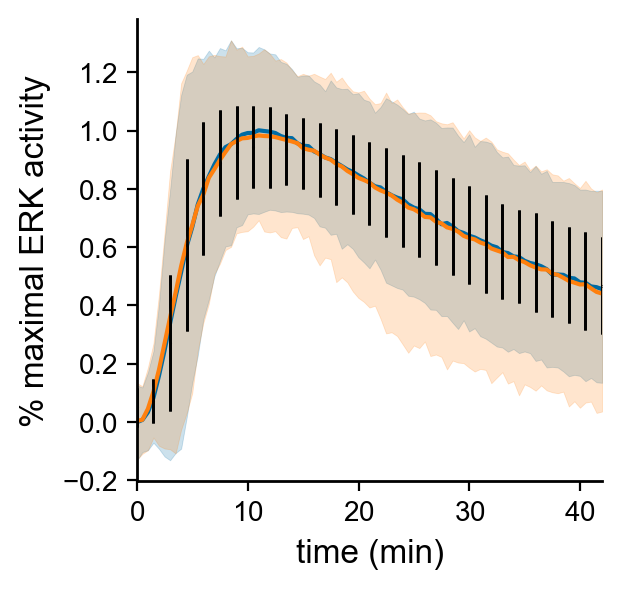

In [6]:
posterior_idata = idata['CYTO'][model_names[0]]
fig, ax = create_posterior_predictive(pymc_model_CYTO, posterior_idata, model, data_CYTO, inputs_CYTO, './', 
            trajectory=True, times=times_CYTO/data_time_to_mins, data_std=data_std_CYTO)

fig, ax = create_posterior_predictive(pymc_model_CYTO_rap1_KD, posterior_idata, model, data_CYTO, inputs_CYTO, './', 
            trajectory=True, times=times_CYTO/data_time_to_mins, data_std=data_std_CYTO, fig_ax=(fig, ax))

Sampling: [llike]


(2000, 87)


Sampling: [llike]


(2000, 87)


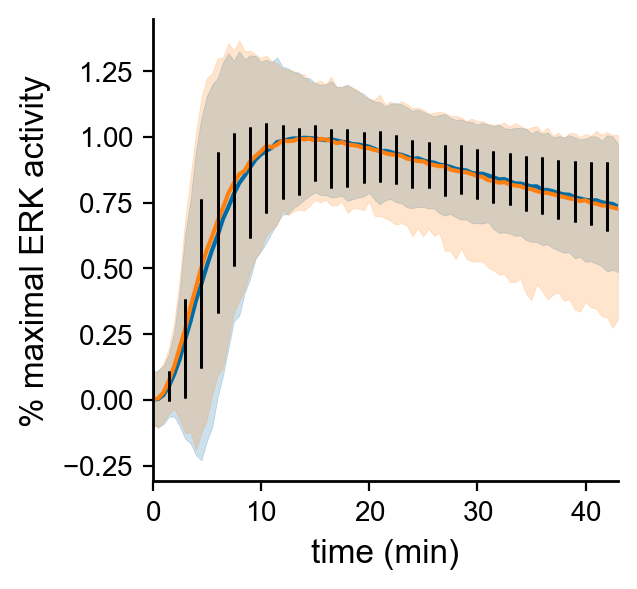

In [7]:
posterior_idata = idata['PM'][model_names[0]]
fig, ax = create_posterior_predictive(pymc_model_PM, posterior_idata, model, data_PM, inputs_PM, './', 
            trajectory=True, times=times_PM/data_time_to_mins, data_std=data_std_PM)

fig, ax = create_posterior_predictive(pymc_model_PM_rap1_KD, posterior_idata, model, data_PM, inputs_PM, './', 
            trajectory=True, times=times_PM/data_time_to_mins, data_std=data_std_PM, fig_ax=(fig, ax))

### Fit interpolator to the data to get at exactly same times for two compartments

In [5]:
# use diffrax linear interpolation to get the MAPK activity at specific time point over 40mins
data_CYTO_interp = diffrax.LinearInterpolation(times_CYTO, data_CYTO)
data_std_CYTO_interp = diffrax.LinearInterpolation(times_CYTO, data_std_CYTO)
data_PM_interp = diffrax.LinearInterpolation(times_PM, data_PM)
data_std_PM_interp = diffrax.LinearInterpolation(times_PM, data_std_PM)

times = np.linspace(0, 42, 85)*60

data_CYTO_new = data_CYTO_interp.evaluate(times)
data_std_CYTO_new = data_std_CYTO_interp.evaluate(times)
data_PM_new = data_PM_interp.evaluate(times)
data_std_PM_new = data_std_PM_interp.evaluate(times)

Now we want to try building a PyMC model that allows for some shared params between the two compartments

In [6]:
# Create jax functions to solve # 
def sol_op_jax(*params):
    pred, _ = ERK_stim_traj(params, diffrax.ODETerm(model), np.max(times/data_time_to_mins), y0_EGF_ins_CYTO[0], ERK_indices)
    return jnp.vstack((pred))

# get the jitted versions
sol_op_jax_jitted = jax.jit(sol_op_jax)


# Create pytensor Op and register with jax # 
class StimRespOp(Op):
    def make_node(self, *inputs):
        # Convert our inputs to symbolic variables
        inputs = [pt.as_tensor_variable(inp) for inp in inputs]
        # Assume the output to always be a float64 matrix
        outputs = [pt.matrix()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        # print('inputs:', inputs)
        result = sol_op_jax_jitted(*inputs)
        # added 3/25 to deal with NaNs
        # Note this is a temporary/ad hoc fix where we penalize param combos that cause computational
        # issues by setting their value to zero so they review a lower likelihood
        if jnp.any(jnp.isnan(jnp.array(result))):
            # print as a way to see if this is an issue
            print('Warning: NaNs in the result. Setting to zeros.')
            # print(inputs)
            result = jnp.zeros_like(result)
        outputs[0][0] = np.asarray(result, dtype="float64")
    
    def grad(self, inputs, output_grads):
        raise NotImplementedError("PyTensor gradient of StimRespOp not implemented")


# construct Ops and register with jax_funcify
sol_op = StimRespOp()

@jax_funcify.register(StimRespOp)
def sol_op_jax_funcify(op, **kwargs):
    return sol_op_jax

compartments = ['CYTO', 'PM']
comps = np.ndarray((0,1), dtype=object)
data_dict = {'CYTO':[data_CYTO_new], 'PM':[data_PM_new]}
data_std_dict = {'CYTO':[data_std_CYTO_new], 'PM':[data_std_PM_new]}

data_new = np.concatenate((data_CYTO_new, data_PM_new), axis=0)
data_std_new = np.concatenate((data_std_CYTO_new, data_std_PM_new), axis=0)

# Construct the PyMC model # 
coords = {'compartment': compartments}
pymc_model = pm.Model(coords=coords)
with pymc_model:
    
    # loop over free params and construct the priors
    priors = []
    for key, value in prior_param_dict.items():
        # create PyMC variables for each parameters in the model
        if key != 'k1_C3G_Deactivation':# or key != 'kcat_Rap1_Activation':
            prior = eval(value)
            priors.append(prior)
    # now for the k1_C3G_Deactivation parameter which we want to be different between compartments
    k1_C3G_Deactivation_CYTO = pm.LogNormal("k1_C3G_Deactivation_CYTO",sigma=0.7804389020524362, mu=0.9162907318741551)
    k1_C3G_Deactivation_PM = pm.LogNormal("k1_C3G_Deactivation_PM",sigma=0.7804389020524362, mu=0.9162907318741551)
    

    # predict dose response
    prediction_CYTO = sol_op(*priors, k1_C3G_Deactivation_CYTO)
    prediction_PM = sol_op(*priors, k1_C3G_Deactivation_PM)

    # assume a normal model for the data
    # sigma specified by the data_sigma param to this function
    llike_CYTO = pm.Normal("llike_CYTO", mu=prediction_CYTO, sigma=[data_std_CYTO_new], observed=[data_CYTO_new])
    llike_PM = pm.Normal("llike_PM", mu=prediction_PM, sigma=[data_std_PM_new], observed=[data_PM_new])

In [7]:
posterior_idata = smc_pymc(pymc_model, 'orton_2009', './', 
            nsamples=100, ncores=1, threshold=0.999, 
            chains=1,correlation_threshold=0.001)

Initializing SMC sampler...
Sampling 1 chain in 1 job


Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
# k1_C3G_Deactivation_CYTO = posterior_idata.posterior['k1_C3G_Deactivation_CYTO']
# new = k1_C3G_Deactivation_CYTO.copy()
# new = 0*np.linspace(1e-5, 2000, num=4000).reshape(new.shape)
# # type(k1_C3G_Deactivation_CYTO)
# new = xr.DataArray(new, dims=('chain','draw'))
# posterior_idata.posterior['k1_C3G_Deactivation_CYTO'] = new

In [9]:
with pymc_model:
        posterior_predictive_double = pm.sample_posterior_predictive(posterior_idata, model=pymc_model,)

Sampling: [llike_CYTO, llike_PM]


In [41]:
posterior_llike_CYTO = np.squeeze(posterior_predictive_double.posterior_predictive['llike_CYTO'].values)
posterior_llike_PM = np.squeeze(posterior_predictive_double.posterior_predictive['llike_PM'].values)
# posterior_llke_CYTO = np.reshape(posterior_llike_CYTO, (posterior_llike_CYTO.shape[0]*posterior_llike_CYTO.shape[1], posterior_llike_CYTO.shape[2]))
# posterior_llike_PM = np.reshape(posterior_llike_PM, (posterior_llike_PM.shape[0]*posterior_llike_PM.shape[1], posterior_llike_PM.shape[2]))

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='time (min)', ylabel='% maximal ERK activity'>)

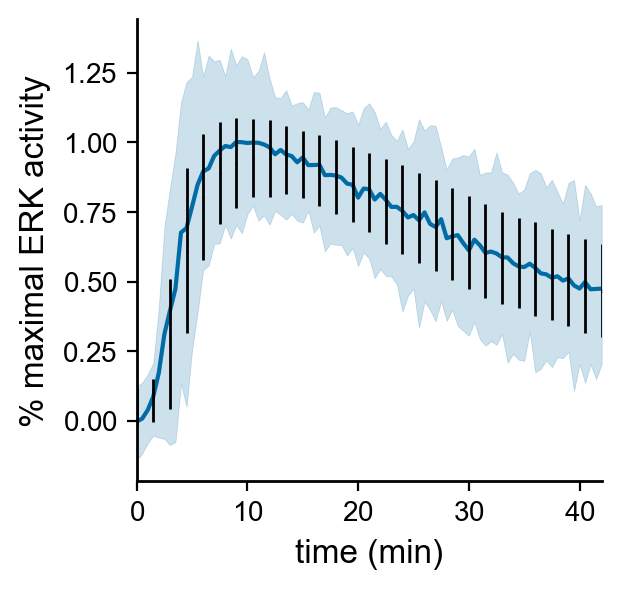

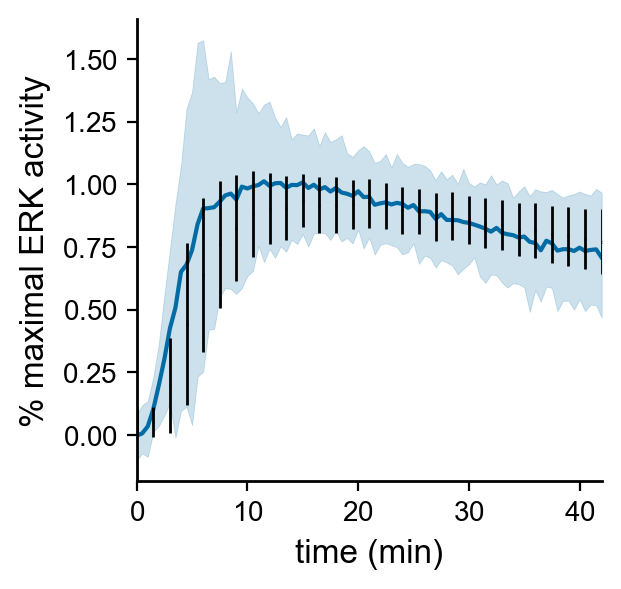

In [14]:
fig, ax = plt.subplots(1,1, figsize=(3.0,3.0))
plot_trajectory_responses_oneAxis(fig, ax, posterior_llike_CYTO, data_CYTO_new, inputs_native_units_CYTO, times/time_conversion_factor, '_', input_name='EGF', 
    output_name='% maximal ERK activity', data_std=data_std_CYTO_new, data_downsample=3, colors=['c', 'g', 'b'], width=3.0, height=3.0)

fig1, ax1 = plt.subplots(1,1, figsize=(3.0,3.0))
plot_trajectory_responses_oneAxis(fig1, ax1, posterior_llike_PM, data_PM_new, inputs_native_units_PM, times/time_conversion_factor, '_', input_name='EGF', 
    output_name='% maximal ERK activity', data_std=data_std_PM_new, data_downsample=3, colors=['c', 'g', 'b'], width=3.0, height=3.0)

<Axes: ylabel='Proportion'>

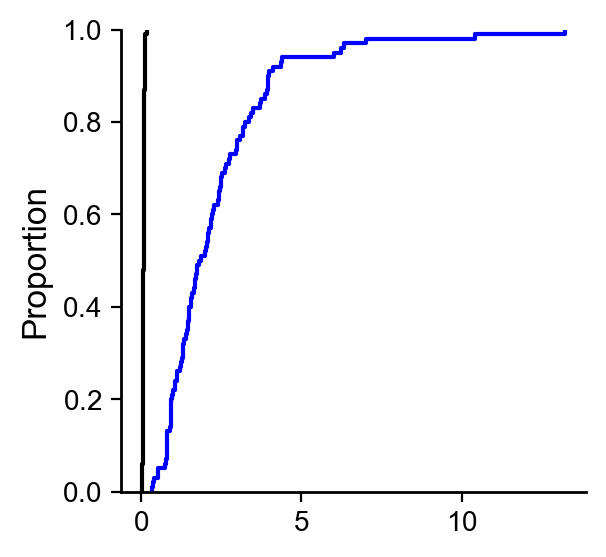

In [53]:
cyto = np.reshape(np.squeeze(np.array(posterior_idata.posterior['k1_C3G_Deactivation_CYTO'])), (-1,))
pm_ = np.reshape(np.squeeze(np.array(posterior_idata.posterior['k1_C3G_Deactivation_PM'])), (-1,))
fig, ax = plt.subplots(1,1, figsize=(3.0,3.0))
dat = pd.DataFrame({'CYTO':cyto, 
                    'PM':pm_})
sns.ecdfplot(dat, ax=ax, 
            palette=['blue', 'black'], 
            legend=False, linewidth=1.5)

In [71]:
prior_param_dict

{'k1_Sos_Deactivation': 'pm.LogNormal("k1_Sos_Deactivation",sigma=0.3902194510262181, mu=0.9162907318741551, )',
 'k1_EGF_Binding_Unbinding': 'pm.ConstantData("k1_EGF_Binding_Unbinding", 2.18503e-05)',
 'PP2AActive': 'pm.ConstantData("PP2AActive", 120000.0)',
 'k2_EGF_Binding_Unbinding': 'pm.ConstantData("k2_EGF_Binding_Unbinding", 0.0121008)',
 'k1_EGFReceptor_Degradation_Free': 'pm.ConstantData("k1_EGFReceptor_Degradation_Free", 0.00125)',
 'k1_EGFReceptor_Degradation': 'pm.ConstantData("k1_EGFReceptor_Degradation", 0.2)',
 'k1_Akt_Deactivation': 'pm.ConstantData("k1_Akt_Deactivation", 0.005)',
 'k1_PI3K_Deactivation': 'pm.ConstantData("k1_PI3K_Deactivation", 0.005)',
 'Rap1Gap': 'pm.ConstantData("Rap1Gap", 120000.0)',
 'Kcat_Erk_Activation': 'pm.ConstantData("Kcat_Erk_Activation", 9.85367)',
 'k1_P90Rsk_Deactivation': 'pm.LogNormal("k1_P90Rsk_Deactivation",sigma=0.3902194510262179, mu=-5.298317366548036, )',
 'Kcat_Mek_Deactivation': 'pm.ConstantData("Kcat_Mek_Deactivation", 2.83243

In [68]:
pname_lst = list(p_dict.keys())
print(pname_lst.index('k1_C3G_Deactivation'))
print(pname_lst.index('k1_P90Rsk_Deactivation'))
idx1 = 0
idx2 = 10
tmp = ['TEST'] + pname_lst[idx1+1:idx2] + ['TEST'] + pname_lst[idx2+1:]
print(tmp)
print(pname_lst)

58
10
['TEST', 'k1_EGF_Binding_Unbinding', 'PP2AActive', 'k2_EGF_Binding_Unbinding', 'k1_EGFReceptor_Degradation_Free', 'k1_EGFReceptor_Degradation', 'k1_Akt_Deactivation', 'k1_PI3K_Deactivation', 'Rap1Gap', 'Kcat_Erk_Activation', 'TEST', 'Kcat_Mek_Deactivation', 'Kcat_Mek_Activation', 'Kcat_Raf1_Deactivation', 'Kcat_Raf1_Activation', 'Kcat_Ras_Deactivation', 'Kcat_Ras_Activation', 'Kcat_Sos_Activation', 'kcat_bRaf_Activation_Ras', 'km_bRaf_Activation_Ras', 'kcat_Mek_Activation_bRaf', 'kcat_bRaf_Deactivation', 'kcat_bRaf_Activation', 'kcat_Rap1_Deactivation', 'kcat_Rap1_Activation', 'kcat_C3G_Activation', 'km_Mek_Activation_bRaf', 'km_bRaf_Deactivation', 'km_bRaf_Activation', 'km_Rap1_Deactivation', 'km_Rap1_Activation', 'km_C3G_Activation', 'Raf1PPtase', 'km_Raf1_Deactivation_Akt', 'km_Akt_Activation', 'km_PI3K_Activation_Ras', 'km_PI3K_Activation_EGFR', 'km_Sos_Feedback_Deactivation', 'km_P90Rsk_Activation', 'km_Erk_Deactivation', 'km_Erk_Activation', 'km_Mek_Deactivation', 'km_Mek_A

In [56]:
def pymc_model_func_C3G(prior_param_dict, sol_op, data, data_sigma):
    pymc_model = pm.Model()
    with pymc_model:
        # loop over free params and construct the priors
        priors = []
        for key, value in prior_param_dict.items():
            # create PyMC variables for each parameters in the model
            if key != 'k1_C3G_Deactivation':# or key != 'kcat_Rap1_Activation':
                prior = eval(value)
                priors.append(prior)
        # now for the k1_C3G_Deactivation parameter which we want to be different between compartments
        k1_C3G_Deactivation_CYTO = pm.LogNormal("k1_C3G_Deactivation_CYTO",sigma=0.7804389020524362, mu=0.9162907318741551)
        k1_C3G_Deactivation_PM = pm.LogNormal("k1_C3G_Deactivation_PM",sigma=0.7804389020524362, mu=0.9162907318741551)
        

        # predict dose response
        prediction_CYTO = sol_op(*priors, k1_C3G_Deactivation_CYTO)
        prediction_PM = sol_op(*priors, k1_C3G_Deactivation_PM)

        # assume a normal model for the data
        # sigma specified by the data_sigma param to this function
        llike_CYTO = pm.Normal("llike_CYTO", mu=prediction_CYTO, sigma=[data_std_CYTO_new], observed=[data_CYTO_new])
        llike_PM = pm.Normal("llike_PM", mu=prediction_PM, sigma=[data_std_PM_new], observed=[data_PM_new])

    return pymc_model

def pymc_model_func_p90RsKSoS(prior_param_dict, sol_op, data, data_sigma):
    pymc_model = pm.Model()
    with pymc_model:
        # loop over free params and construct the priors
        priors = []
        for key, value in prior_param_dict.items():
            # create PyMC variables for each parameters in the model
            if key not in ['k1_P90Rsk_Deactivation', 'k1_Sos_Deactivation']:
                prior = eval(value)
                priors.append(prior)
            else:
                prior.append(None)
        # now for k1_p90Rsk_Deactivation and k1_Sos_Deactivation parameter which we want to be different between compartments
        k1_P90Rsk_Deactivation_CYTO = pm.LogNormal("k1_P90Rsk_Deactivation_CYTO",sigma=0.3902194510262181, mu=-5.298317366548036)
        k1_P90Rsk_Deactivation_PM = pm.LogNormal("k1_P90Rsk_Deactivation_PM",sigma=0.3902194510262181, mu=-5.298317366548036)
        k1_Sos_Deactivation_CYTO = pm.LogNormal("k1_Sos_Deactivation_CYTO",sigma=0.3902194510262181, mu=0.9162907318741551)
        k1_Sos_Deactivation_PM = pm.LogNormal("k1_Sos_Deactivation_PM",sigma=0.3902194510262181, mu=0.9162907318741551)
        

        # predict dose response
        prediction_CYTO = sol_op(*priors, k1_C3G_Deactivation_CYTO)
        prediction_PM = sol_op(*priors, k1_C3G_Deactivation_PM)

        # assume a normal model for the data
        # sigma specified by the data_sigma param to this function
        llike_CYTO = pm.Normal("llike_CYTO", mu=prediction_CYTO, sigma=[data_std_CYTO_new], observed=[data_CYTO_new])
        llike_PM = pm.Normal("llike_PM", mu=prediction_PM, sigma=[data_std_PM_new], observed=[data_PM_new])

    return pymc_model

def build_pymc_model(prior_param_dict, data, y0_EGF_inputs, 
                    output_states, max_time, model_dfrx_ode, model_func=None, 
                    simulator=ERK_stim_response, data_sigma=0.1):
    """ Builds a pymc model object for the MAPK models.

    Constructs priors for the model, and uses the ERK_stim_response function to 
    generate the stimulus response function and likelihood.
    
    If model is None, the function will use the default model. If a model is s
    pecified, it will use that model_func function to create a PyMC model.

    """

    
    # Create jax functions to solve # 
    def sol_op_jax(*params):
        pred, _ = simulator(params, model_dfrx_ode, max_time, y0_EGF_inputs, output_states)
        return jnp.vstack((pred))

    # get the jitted versions
    sol_op_jax_jitted = jax.jit(sol_op_jax)

    
    # Create pytensor Op and register with jax # 
    class StimRespOp(Op):
        def make_node(self, *inputs):
            # Convert our inputs to symbolic variables
            inputs = [pt.as_tensor_variable(inp) for inp in inputs]
            # Assume the output to always be a float64 matrix
            outputs = [pt.matrix()]
            return Apply(self, inputs, outputs)

        def perform(self, node, inputs, outputs):
            
            result = sol_op_jax_jitted(*inputs)
            # added 3/25 to deal with NaNs
            # Note this is a temporary/ad hoc fix where we penalize param combos that cause computational
            # issues by setting their value to zero so they review a lower likelihood
            if jnp.any(jnp.isnan(jnp.array(result))):
                # print as a way to see if this is an issue
                print('Warning: NaNs in the result. Setting to zeros.')
                # print(inputs)
                result = jnp.zeros_like(result)
            outputs[0][0] = np.asarray(result, dtype="float64")
        
        def grad(self, inputs, output_grads):
            raise NotImplementedError("PyTensor gradient of StimRespOp not implemented")


    # construct Ops and register with jax_funcify
    sol_op = StimRespOp()

    @jax_funcify.register(StimRespOp)
    def sol_op_jax_funcify(op, **kwargs):
        return sol_op_jax
    
    
    # Construct the PyMC model # 
    if model_func is not None:
        model = model_func(prior_param_dict, sol_op, data, data_sigma)
    else:
        model = pm.Model()
        with model:
            # loop over free params and construct the priors
            priors = []
            for key, value in prior_param_dict.items():
                # create PyMC variables for each parameters in the model
                prior = eval(value)
                priors.append(prior)

            # predict dose response
            prediction = sol_op(*priors)

            # assume a normal model for the data
            # sigma specified by the data_sigma param to this function
            llike = pm.Normal("llike", mu=prediction, sigma=data_sigma, observed=data)

    return model

In [57]:
pm_model_C3G_rap1KD = build_pymc_model(prior_param_dict, None, y0_EGF_ins_CYTO_rap1_KD[0], 
                    ERK_indices, np.max(times)/time_conversion_factor, diffrax.ODETerm(model), 
                    model_func=pymc_model_func_C3G, simulator=ERK_stim_traj_CYTO)

pm_model_p90RsKSoS = build_pymc_model(prior_param_dict, None, y0_EGF_ins_CYTO[0], 
                    ERK_indices, np.max(times)/time_conversion_factor, diffrax.ODETerm(model), 
                    model_func=pymc_model_func_C3G, simulator=ERK_stim_traj_CYTO)

pm_model_p90RsKSoS_Rap1KD = build_pymc_model(prior_param_dict, None, y0_EGF_ins_CYTO[0], 
                    ERK_indices, np.max(times)/time_conversion_factor, diffrax.ODETerm(model), 
                    model_func=pymc_model_func_C3G, simulator=ERK_stim_traj_CYTO)

In [38]:
with pm_model:
        posterior_predictive_ = pm.sample_posterior_predictive(posterior_idata, model=pm_model,)

Sampling: [llike_CYTO, llike_PM]


(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='time (min)', ylabel='% maximal ERK activity'>)

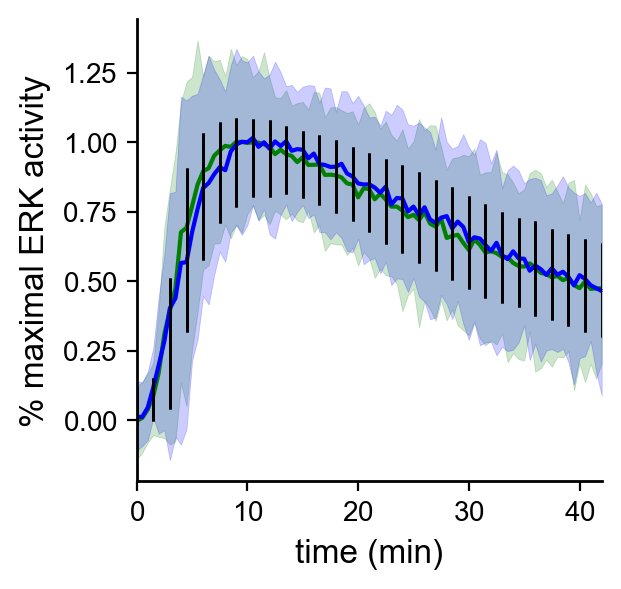

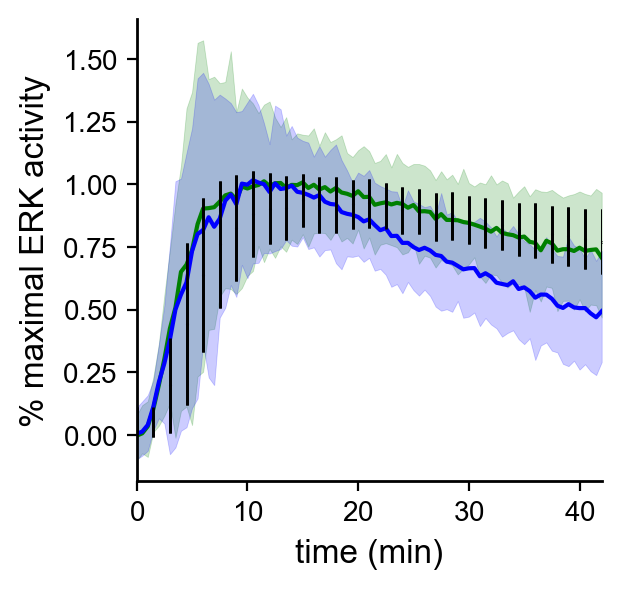

In [46]:
posterior_llike_CYTO_rap1KD = np.squeeze(posterior_predictive_.posterior_predictive['llike_CYTO'].values)
posterior_llike_PM_rap1KD = np.squeeze(posterior_predictive_.posterior_predictive['llike_PM'].values)

fig, ax = plt.subplots(1,1, figsize=(3.0,3.0))
plot_trajectory_responses_oneAxis(fig, ax, posterior_llike_CYTO, data_CYTO_new, inputs_native_units_CYTO, times/time_conversion_factor, '_', input_name='EGF', 
    output_name='% maximal ERK activity', data_std=data_std_CYTO_new, data_downsample=3, colors=['g'], width=3.0, height=3.0)
plot_trajectory_responses_oneAxis(fig, ax, posterior_llike_CYTO_rap1KD, data_CYTO_new, inputs_native_units_CYTO, times/time_conversion_factor, '_', input_name='EGF', 
    output_name='% maximal ERK activity', data_std=data_std_CYTO_new, data_downsample=3, colors=['b'], width=3.0, height=3.0)

fig1, ax1 = plt.subplots(1,1, figsize=(3.0,3.0))
plot_trajectory_responses_oneAxis(fig1, ax1, posterior_llike_PM, data_PM_new, inputs_native_units_PM, times/time_conversion_factor, '_', input_name='EGF', 
    output_name='% maximal ERK activity', data_std=data_std_PM_new, data_downsample=3, colors=['g'], width=3.0, height=3.0)
plot_trajectory_responses_oneAxis(fig1, ax1, posterior_llike_PM_rap1KD, data_PM_new, inputs_native_units_PM, times/time_conversion_factor, '_', input_name='EGF', 
    output_name='% maximal ERK activity', data_std=data_std_PM_new, data_downsample=3, colors=['b'], width=3.0, height=3.0)